## 1. Imports & Set up

In [1]:
import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv
import os
import asyncio
import json
import certifi

from pymongo import MongoClient, UpdateOne
from pymongo.server_api import ServerApi

from datetime import datetime, timedelta
from urllib.request import urlopen

from difflib import SequenceMatcher
import requests

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_mongodb.vectorstores import MongoDBAtlasVectorSearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import interrupt

import asyncio, nest_asyncio
from typing import Dict, List, Any, Optional, Literal, Union
from bson import ObjectId
from collections import defaultdict

from openai import OpenAI, AsyncOpenAI
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field, field_validator

from IPython.display import Image, display

from tavily import TavilyClient, AsyncTavilyClient

In [3]:
load_dotenv(".env", override=True)

OpenAI_api_key = os.getenv("OpenAI_api_key")
llm_model = "gpt-5-nano"
embed = OpenAIEmbeddings(model="text-embedding-3-small", api_key=OpenAI_api_key)
llm_client = OpenAI(api_key=OpenAI_api_key)

financialmodellingprep_api_key = os.getenv("financialmodellingprep_api_key")

tavily_api_key = os.getenv("tavily_api_key")

## 2. Input Handling & Global State Set up

In [63]:
class InputTicker_State(BaseModel):
    ticker: str = Field(description="The stock ticker symbol, e.g., AAPL for Apple Inc.")
    user_query: Optional[str]
    name: str = Field(description="The name of the company associated with the ticker symbol.")
    industry: str = Field(description="The industry of the company associated with the ticker symbol.")
    firm_description: Optional[str] = Field(description="A brief description of the company.")

    exchange: Optional[str] = Field(description="The stock exchange where the ticker is listed, e.g., NASDAQ, NYSE.")
    one_weekb4_today: str = Field(description = "yyyy-mm-dd date that is 1 week b4 today to get latest articles")
    
    is_valid_input: Literal["valid", "invalid"] = Field(description="Indicates whether the input ticker is valid or not.")
    error_message: Optional[str]

    internet_search_query: List[str] = Field(description="The search queries generated using llm based on the user's input.")
    tavily_article_list: Optional[List[Dict]] = Field(description="stores articles from tavily extraction")
    useful_articles_list: Optional[List[Dict]] = Field(description="stores articles as it flows thru the graph")

    news_answer: str = Field("Summarised final news to give to the end user")
    bullish_act: Any = Field("What to do to profit from this information")
    bearish_act: Any = Field("What to do to prevent bad events from affecting my stocks")

In [40]:
def llm_extract(state: InputTicker_State) -> InputTicker_State:

    if state.error_message:
        prompt = f"{state.error_message}\n\n Please retry (examples: 'NVDA latest news related to semiconductor industry'):"
    else:
        prompt = "Enter your stock/news query (examples: 'NVDA latest earnings')"

    # pause graph and request input from user
    # EVEN for the very first time - it will interrupt and start here
    # if there is a mistake after validation, it will interrupt and ask for new input from user before going back to validation node
    new_input = interrupt({"prompt": prompt})
    
    """ If I change state.user_query, this will only change the local state NOT global state unless I return the state as a whole BUT 
    that might mean updating things that havent changed, bad if those variables are super long"""

    response = llm_client.chat.completions.create(
        model=llm_model,
        messages=[
            {
                "role": "system",
                "content": (
                    "Extract ONE US-listed stock ticker if it is explicitly there, and a search query from the user's message.\n"
                    "Rules:\n"
                    "- Output exactly one ticker.\n"
                    "- If multiple tickers appear, choose the most central one.\n"
                    "- Keep the query short, specific, and suitable for web/news search.\n"
                    "- Do not add extra fields or commentary."
                    "- Return ONLY a JSON object with fields: ticker, query"
                )
            },
            {
                "role": "user",
                "content": f"""{new_input}"""
            }
        ]
    )

    answer = json.loads(response.choices[0].message.content.strip())
    print(answer)
    return {
        "ticker": answer.get("ticker"),
        "user_query": answer.get("query"),
        "error_message": ""
    }

In [34]:
def validate_input(state: InputTicker_State) -> InputTicker_State:

    response = llm_client.chat.completions.create(
        model=llm_model,
        messages=[
            {
                "role": "system",
                "content": (
                    "Validate if this is a valid stock and news related search request. Be strict. If it is not valid return an error message saying invalid and"
                    "detailing why its not valid else return 1 word valid"
                )
            },
            {
                "role": "user",
                "content": f"Ticker: {state.ticker}\n Query: {state.user_query}\n"
            }
        ]
    )

    answer = response.choices[0].message.content.strip()
    print(answer)

    if answer == "valid":
        return {"is_valid_input": "valid", 
                "error_message": ""
                }
    else:
        return {"is_valid_input": "invalid", 
                "error_message": answer
                }

In [48]:
def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

def handle_ticker_input(state: InputTicker_State) -> Dict[str, Any]:
    search_ticker_endpoint = (
        "https://financialmodelingprep.com/stable/profile?symbol=" + 
        state.ticker + 
        "&apikey=" + financialmodellingprep_api_key + 
        "&limit=1"
    )
    
    try:
        result = get_jsonparsed_data(search_ticker_endpoint)
        
        # Return a dictionary with the fields to update
        return {
            "ticker": result[0]['symbol'],
            "name": result[0]['companyName'],
            "exchange": result[0].get('exchange', None),
            "industry": result[0].get('industry', None),
            "firm_description": result[0].get('description', None)
        }
    
    except IndexError as ie: 
        print("Please key in a valid ticker")
        raise ValueError(f"Invalid ticker: {state.ticker}")
    except Exception as e:
        print(f"Error handling ticker input for {state.ticker}: {e}")
        raise e

## 3. News Search Section

In [8]:
class ArticleLLMFields(BaseModel):
    """Analysis of a news article for relevance and key information extraction"""
    keep: bool = Field(description="Whether to keep this article for further analysis")
    keep_score: float = Field(description="Score indicating relevance/quality of the article (0-1 or 0-10 scale)",ge=0, le=1)
    keep_reason: str = Field(description="Explanation for why the article should be kept or discarded")
    
    primary_topic: str = Field(description="The main topic or theme of the article")
    topics: List[str] = Field(description="List of all relevant topics covered in the article")
    
    stance: Literal["bullish", "bearish", "neutral", "unclear"] = Field(description="Market stance conveyed by the article: bullish (positive), bearish (negative), neutral, or unclear")
    time_horizon: Literal["short", "medium", "long", "unclear"] = Field(description="Time horizon of the impact: short (<1 year), medium (1-3 years), long (>3 years), or unclear")
        
    text_for_rag: str = Field(description="Information-dense text preserving all numbers, dates, and entities for RAG system")
    summary: str = Field(description="Concise summary of the article in 2-6 sentences", min_length=20)

class ArticleFields(BaseModel):
    news_url: str
    title: str
    score: float
    published_date: str
    content: str
    llm_output: ArticleLLMFields

In [37]:
# OLD NOT USED ANYMORE BUT KEEP FOR REFERENCE
async def search_query(query: str, tavily_client):
    """Run a single Tavily search query asynchronously
    tavily_client.search() is a synchronous blocking function (it's not actually async, even though you wrote async def)
    """
    result = await tavily_client.search(
        query=query,
        max_results=2,
        topic="news",
        search_depth="advanced",
        days=7,
        include_raw_content=True,
        exclude_domains=["linkedin.com", "youtube.com", "wikipedia.com", "facebook.com"]
    )

    return result.get("results", [])

In [10]:
def deduplicate_aggressive(articles: list[dict], min_score: float = 0.3) -> list[dict]:
    """
    More aggressive deduplication using multiple criteria
    """
    unique_articles = []
    seen_urls = set()
    seen_titles = set()
    
    for article in articles:
        # exclude articles with bad score < 0.3
        if article.get('score', min_score) < min_score:
            continue

        url = article.get('url', '')
        title = article.get('title', '').lower().strip()
        title = title[:title.rfind("-")].strip()
        
        # Skip if URL or exact title already seen
        if url in seen_urls or title in seen_titles:
            continue
        
        # Check for very similar titles (fuzzy matching)
        is_similar = False
        for seen_title in seen_titles:
            similarity = SequenceMatcher(None, title, seen_title).ratio()
            if similarity > 0.75:  # 75% similar
                is_similar = True
                break
        
        if not is_similar:
            unique_articles.append(article)
            seen_urls.add(url)
            seen_titles.add(title)
    
    return unique_articles

In [50]:
def generate_internet_search_query(state: InputTicker_State) -> Dict[str, List[str]]:
    """
    Generate 2 concise web/news search queries and store them in state.internet_search_query (List[str]).
    """

    response = llm_client.chat.completions.create(
        model=llm_model,
        messages=[
            {
                "role": "system",
                "content": (
                    "You create web/news search queries.\n"
                    "Return ONLY valid JSON with this exact schema:\n"
                    "{\n"
                    '  "internet_search_query": ["<query1>", "<query2>"]\n'
                    "}\n"
                    "Rules:\n"
                    "You create web/news search queries for INVESTOR GUIDANCE monitoring.\n"
                    "Return ONLY valid JSON with this exact schema:\n"
                    "{\n"
                    '  "internet_search_query": ["<query1>", "<query2>"]\n'
                    "}\n"
                    "Rules:\n"
                    "- Exactly 2 queries.\n"
                    "- Each query <= 12 words.\n"
                    "- Query1 MUST target guidance/earnings changes (e.g., guidance raised/cut, outlook, forecast, EPS/revenue).\n"
                    "- Query2 MUST target context/drivers (industry trend, demand, pricing, regulation, competitors).\n"
                    "- Always include the anchor (ticker and/or company) in Query1.\n"
                    "- Query2 may include anchor OR just industry/macro terms depending on user intent.\n"
                    "- Use widely used finance terms: earnings, guidance, outlook, forecast, raises, cuts, revises.\n"
                    "- No bullet points, no extra text, JSON only."
                ),
            },
            {
                "role": "user",
                "content": (
                    f"User original query: {state.user_query}\n"
                    f"Validated ticker: {state.ticker}\n"
                    f"Company name: {state.name}\n"
                    f"Industry: {state.industry}\n"
                ),
            },
        ],
    )

    raw = (response.choices[0].message.content or "").strip()

    # Parse JSON robustly
    try:
        data = json.loads(raw)
        queries = data.get("internet_search_query", [])

    except json.JSONDecodeError:
        # Fallback: split lines / bullets if model didn't follow instructions
        lines = [ln.strip("-• \t") for ln in raw.splitlines() if ln.strip()]
        queries = lines[:2]

    # Final sanitisation
    queries = [q.strip() for q in queries if isinstance(q, str) and q.strip()]

    # Ensure exactly 2 queries (fallback if needed)
    if len(queries) < 2:
        queries = queries + [
            f"{state.ticker} latest news",
            f"{state.industry} latest news",
        ]
        queries = queries[:2]

    elif len(queries) > 2:
        queries = queries[:2]

    print(f"Generated internet_search_query: {queries}")
    return {"internet_search_query": queries}

In [69]:
async def run_parallel_searches(state: InputTicker_State) -> Dict[str, Any]:
    # Initialize async client
    tavily_client = AsyncTavilyClient(api_key=tavily_api_key)

    """Run both queries in parallel"""
    query1 = state.internet_search_query[0]
    query2 = state.internet_search_query[1]
    
    print("Trying to extract news from online sites using tavily")
    # Run both queries concurrently
    results = await asyncio.gather(
        *(tavily_client.search(
            query=q,
            max_results=2,
            topic="news",
            search_depth="advanced",
            days=7,
            include_raw_content=True,
            exclude_domains=["linkedin.com", "youtube.com", "wikipedia.com", "facebook.com"]
            )
        for q in [query1, query2]
        ) 
    )
    
    articles_query1 = results[0].get("results", [])
    articles_query2 = results[1].get("results", [])
    
    # Combine results if needed
    all_articles = deduplicate_aggressive(articles_query1 + articles_query2)
    # print(all_articles)
    print("Extracted news from online sites using tavily")
    
    return {"tavily_article_list" : all_articles}

In [67]:
SYSTEM_PROMPT = f"""You are a financial-news traige assistant.
    Use ONLY the provided article content and metadata. Do not add external facts.
    If the content is paywalled, boilerplate, or not substantively about the subject, set keep=false.

    Output MUST be valid JSON matching the schema.
"""

def build_user_prompt(article: Dict[str, Any], subject_hint: Optional[str] = None) -> str:
    """
    subject_hint: optional (e.g., ticker name) to help the LLM judge relevance when extending project to 1 stock.
    """
    url = article.get("url", "")
    title = article.get("title", "")
    published_date = article.get("published_date", "")
    score = article.get("score", None)
    content = (article.get("content") or "").strip()

    # Keep prompts stable: truncate very long pages
    if len(content) > 14000:
        content = content[:11000] + "\n...\n" + content[-2500:]

    hint_line = f"Subject hint: {subject_hint}\n" if subject_hint else ""

    return f"""{hint_line} Metadata:
        - url: {url}
        - title: {title}
        - published_date: {published_date}
        - score: {score}

        Task:
        Read the article content and produce JSON fields as per the schema:
        - Decide keep or not, keep_score and keep_reason
        keep_reason must be of type string
        - Identify primary_topic, topics
        - Determine stance used only these values - ("bullish", "bearish", "neutral", "unclear")
        - Determine time_horizon of the impact based on claims, use only these values - ("short", "medium", "long") where short is <1Year, medium is 1-3 years and long is >3 years
        For stance & time_horizon, if unsure simply return unclear
        - Write text_for_rag (information-dense; preserve numbers/dates/entities)
        - Write summary (2–6 sentences)
        Note that text_for_rag and summary fields must be of type string

        Article content:
        \"\"\"{content}\"\"\"
        """

In [ ]:
async def analyse_one_article_llm(
    llm_client,
    article: Dict[str, Any],
    llm_model: str,
    subject_hint: Optional[str] = None,
    max_retries: int = 1
) -> Dict[str, Any]:
    """
    Returns a new dict:
      {
        ...original article fields...,
        "llm": <ArticleLLMFields as dict>
      }
    Raises if the LLM response can't be validated after retries (handled by caller).
    """

    for attempt in range(max_retries + 1):
        try:
            prompt = build_user_prompt(article, subject_hint=subject_hint)

            resp = llm_client.chat.completions.create(
                model=llm_model,
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": prompt},
                ],
            )

            raw = (resp.choices[0].message.content or "").strip()

            # Validate structured output
            parsed = ArticleLLMFields.model_validate_json(raw)

            article_fields = ArticleFields(
                news_url=article.get("url", "No url"), 
                title=article.get("title", "No title"),
                score=article.get("score", 0.0),
                published_date=article.get("published_date", "No date"),
                content=article.get("content", "No content"),
                llm_output=parsed
            )
            
            return article_fields.model_dump()
        
        # handle failure logic - by retrying twice
        except Exception as e:
            if attempt < max_retries:
                print(f"Attempt {attempt + 1} failed for {article.get('title', 'Unknown title')} due to {e}")
                await asyncio.sleep(1.5)
            else:
                print(f"Final attempt failed for {article.get('title', 'Unknown title')}")
                return {}


In [14]:
async def process_all_articles_node(state: InputTicker_State) -> Dict[str, Any]:
    """
    LangGraph node that processes all articles with LLM analysis.
    
    Expected state keys:
        - articles: List[Dict[str, Any]] - processed articles from Tavily + LLM output
        - client: OpenAI client
        - model: str - model name
        - subject_hint: Optional[str] - hint for analysis
    
    Returns updated state with:
        - processed_articles: List[ArticleFields] - successfully processed articles
    """
    articles = state.tavily_article_list
    
    print(f"Processing {len(articles)} articles...")
    
    # Process all articles concurrently with retry logic
    tasks = [
        analyse_one_article_llm(
            llm_client= llm_client,
            article= article,
            llm_model= llm_model
        )
        for article in articles
    ]
    
    results = await asyncio.gather(*tasks)
    
    # Separate successful and failed articles
    processed_articles = []
    failed_articles = []
    
    for i, result in enumerate(results):
        if result != {}:
            processed_articles.append(result)
        else:
            failed_articles.append(articles[i])
    
    print(f"Successfully processed: {len(processed_articles)}/{len(articles)}")
    print(f"Failed: {len(failed_articles)}/{len(articles)}")
    
    return {
        "useful_articles_list": processed_articles,
    }

In [72]:
def create_finalReport_node(state: InputTicker_State) -> InputTicker_State:
    articles = state.useful_articles_list

    kept = [a for a in articles if a.get("llm_output").get("keep") is True]
    kept.sort(key=lambda x: x.get("llm_output").get("keep_score", 0.0), reverse=True)

    top_k = kept[:3]
    print(top_k)

    evidence_lines = []
    for index, article in enumerate(top_k, start=1):
        llm_article = article.get("llm_output") or {}

        primary_topic = llm_article.get("primary_topic", "")
        stance =  llm_article.get("stance", "unclear")
        horizon = llm_article.get("time_horizon", "unclear")  # your schema uses time_horizon
        summary = llm_article.get("summary", "")

        evidence_lines.append(
            f"[{index}] topic={primary_topic} | stance={stance}/{horizon}\n"
            f"summary: {summary}"
        )

    evidence = "\n\n".join(evidence_lines)

    response = llm_client.chat.completions.create(
        model=llm_model,
        messages=[
            {
                "role": "system",
                "content": (
                    "I am a finance news synthesiser. I only use the provided article evidence for facts. "
                    "I provide general risk-management and idea-generation guidance for stock trading for RETAIL TRADERS! "
                    "I keep it concise and structured. "
                    "Return ONLY valid JSON matching the schema."
                ),
            },
            {
                "role": "user",
                "content": f"""Query: {state.user_query} Do let me know how I should use this information in stock trading.

                    Article evidence (each item is a separate article; treat as potentially overlapping):
                    {evidence}

                    Task:
                    1) YOU MUST produce JSON fields as per the schema to answer the query in 2–4 sentences, synthesising the main themes across the evidence.
                    2) Give actionables to protect against stock shocks: 3–4 bullet points.
                    3) Give potential opportunities: 3–4 bullet points.

                    Constraints:
                    - Do not invent facts not supported by the evidence.
                    - If evidence is mixed/unclear, say so plainly.
                    - Bullets must be concise and practical.

                    Output Schema (JSON only):
                    - news_answer: string (covers the latest important news)
                    - bullish_act: string (actionables to capitalise on these trends)
                    - bearish_act: string (pitfalls / bearish news to be aware of)
                    """,
            },
        ],
    )

    raw = (response.choices[0].message.content or "").strip()

    # Validate structured output (raw is a JSON string, so parse it)
    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        # Fallback: keep pipeline alive even if the model breaks format
        return {
            "news_answer": "I do not have enough high-confidence articles to answer this query.",
            "bearish_act": "I do not have enough high-confidence articles to answer this query.",
            "bullish_act": "I do not have enough high-confidence articles to answer this query.",
        }

    return {
        "news_answer": parsed.get("news_answer", ""),
        "bullish_act": parsed.get("bullish_act", ""),
        "bearish_act": parsed.get("bearish_act", ""),
    }

## 4. Graph Initialisation & Post workflow Handling

In [73]:
workflow = StateGraph(InputTicker_State)
workflow.add_node("llm_extract", llm_extract)
workflow.add_node("validate_input", validate_input)
workflow.add_node("user_ticker_input", handle_ticker_input)
workflow.add_node("generate_internet_search_query", generate_internet_search_query)
workflow.add_node("Internet_Search_Tool", run_parallel_searches)
workflow.add_node("llm_output_article", process_all_articles_node)
workflow.add_node("llm_generate_ArticleReport", create_finalReport_node)

# Add edges
workflow.add_edge(START, "llm_extract")
workflow.add_edge("llm_extract", "validate_input")
# use path_map for conditional edges instead of ifelse lambda since the mermaid graph visualisation doesnt know what other values can be taken in 
# also cleaner since the graph itself will throw an error if we forget to account for a possible value of is_valid_input
# this is bcos it needs the all possible paths to be defined at graph compile time to visualise them, rather than waiting for runtime like the ifelse lambda function would allow
workflow.add_conditional_edges(
    "validate_input",
    lambda s: s.is_valid_input, 
    path_map={
        "invalid": "llm_extract",
        "valid": "user_ticker_input",
    },
)
workflow.add_edge("user_ticker_input", "generate_internet_search_query")
workflow.add_edge("generate_internet_search_query", "Internet_Search_Tool")
workflow.add_edge("Internet_Search_Tool", "llm_output_article")
workflow.add_edge("llm_output_article", "llm_generate_ArticleReport")
workflow.add_edge("llm_generate_ArticleReport", END)

# Compile the graph
graph = workflow.compile(checkpointer=MemorySaver())

# Create config
config = {"configurable": {"thread_id": "1"}}

# inititalise start state = 
OneWeek_b4 = datetime.now() - timedelta(days = 7)
OneWeek_b4_today = str(OneWeek_b4.year) + "-" + str(OneWeek_b4.month) + "-" + str(OneWeek_b4.day)
initial_state = InputTicker_State(
    ticker= "",
    user_query= "",
    industry= "",
    firm_description= "",
    error_message= "",
    name= "",
    is_valid_input= "valid",
    exchange=None,
    one_weekb4_today=OneWeek_b4_today,
    internet_search_query=[],
    tavily_article_list=None,
    useful_articles_list=None
)

In [65]:
from langgraph.types import Command

# Invoke the graph with initial state (async version)
await graph.ainvoke(initial_state, config)

count = 0
while count < 3:
    count += 1
    snap = await graph.aget_state(config)
    if not snap.next:
        break  # done
    
    payload = snap.tasks[0].interrupts[0].value
    user_text = input(payload["prompt"] + "\n> ")
    
    # Resume by sending the user_text back (async version)
    await graph.ainvoke(Command(resume=user_text), config=config)

# aget is like get BUT async
final = (await graph.aget_state(config)).values

{'ticker': 'MCD', 'query': 'MCD stock news'}
valid


C:\Users\Ramanen\AppData\Local\Temp\ipykernel_25648\3830276017.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


Generated internet_search_query: ["MCD earnings forecast revised for McDonald's", 'Industry trend: fast-food demand and pricing pressures']
Trying to extract news from online sites using tavily
[{'url': 'https://www.cnbc.com/2026/02/12/wall-street-sees-more-upside-for-mcdonalds-after-strong-earnings-beat.html', 'title': 'Wall Street sees more upside for McDonald’s after strong earnings beat - CNBC', 'score': 0.997783, 'published_date': 'Thu, 12 Feb 2026 12:59:21 GMT', 'content': 'beverages & chicken) … We continue to like the setup from here with tangible catalysts to drive SSS outperformance globally and a return to HSD+ EPS growth, and combined with its defensive business model against the current backdrop, we believe MCD offers a favorable risk/reward profile." UBS: buy, $365 UBS\' forecast, raised from $350, was approximately 13% higher than McDonald\'s current price. "Despite gains YTD, we continue to like the setup for MCD shares in \'26 given catalysts to drive mkt share gains &

In [66]:
print("╔" + "="*60 + "╗")
print("║  🐂 💚 BULLISH ACTION" + " "*36 + "║")
print("╠" + "="*60 + "╣")
print(final.get("bullish_act"))
print("\n╠" + "="*60 + "╣")
print("║  🐻 ❤️ BEARISH ACTION" + " "*35 + "║")
print("╠" + "="*60 + "╣")
print(final.get("bearish_act"))
print("\n╠" + "="*60 + "╣")
print("║  📰 NEWS ANALYSIS" + " "*41 + "║")
print("╠" + "="*60 + "╣")
print(final.get("news_answer"))
print("╚" + "="*60 + "╝")

╔============================================================╗
║  🐂 💚 BULLISH ACTION                                    ║
╠============================================================╣
- Prioritize or overweight MCD relative to the sector given the consensus Buy and upside potential.
- Use the $364-$375 price-target band as guidance for entries/exits and set limit orders near pullbacks to these levels.
- Monitor catalysts (4Q SSS momentum, 2026 growth, value initiatives, marketing campaigns, beverage lineup) as indicators of durability.
- Implement risk controls (position sizing, stop-losses or trailing stops) to shield against broader market volatility.

╠============================================================╣
║  🐻 ❤️ BEARISH ACTION                                   ║
╠============================================================╣
- Acknowledge sector risk: Burger King’s miss and ~3% premarket drop suggest near-term caution for restaurant names; avoid over-concentration in one gr

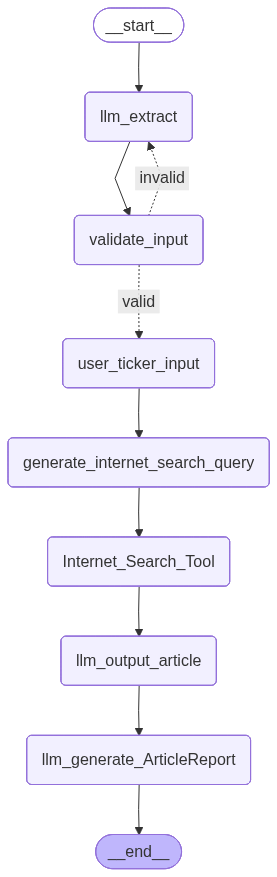

In [68]:
display(Image(graph.get_graph().draw_mermaid_png()))

## 5. Streamlit Page